### Import des Bibliothéques
---

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import  silhouette_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import plotly.express as px

### Chargement des données
---

In [2]:
df = pd.read_csv("data/uber-raw-data-sep14.csv")
df.head()

Date/Time      Lat      Lon    Base
0  9/1/2014 0:01:00  40.2201 -74.0021  B02512
1  9/1/2014 0:01:00  40.7500 -74.0027  B02512
2  9/1/2014 0:03:00  40.7559 -73.9864  B02512
3  9/1/2014 0:06:00  40.7450 -73.9889  B02512
4  9/1/2014 0:11:00  40.8145 -73.9444  B02512

### L'EDA Analyse exploratoire des données Basique 
---

In [3]:
print(f"Nous avons {df.shape[1]} colonnes et {df.shape[0]} lignes dans le jeu de données df_apr14")

print("\n... Informations sur les colonnes et les types de données ...")
df.info() 

print("\n... Statistiques descriptives sur les colonnes numériques ...")
display(df.describe())

print("\n... Valeurs manquantes ...")
nb_valeurs_manquantes = df.isnull().sum()
pourcentage_valeurs_manquantes = (df.isnull().mean() * 100).round(2)
df_manquants = pd.DataFrame({
    'Nombre de Valeurs Manquantes': nb_valeurs_manquantes,
    '% Valeurs Manquantes': pourcentage_valeurs_manquantes
})
# Ne garder que les colonnes avec des valeurs manquantes
df_manquants[df_manquants['Nombre de Valeurs Manquantes'] > 0].sort_values('Nombre de Valeurs Manquantes', ascending=False)
print(df_manquants)

# Vérification des doublons
print(" --- Doublons ---\n")
print("Doublons :", df.duplicated().sum())

# Analyse doublons
print(df[df.duplicated()].head(10))
print("\nCeux ne sont pas de vrai doublons")

Nous avons 4 colonnes et 1028136 lignes dans le jeu de données df_apr14

... Informations sur les colonnes et les types de données ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028136 entries, 0 to 1028135
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Date/Time  1028136 non-null  object 
 1   Lat        1028136 non-null  float64
 2   Lon        1028136 non-null  float64
 3   Base       1028136 non-null  object 
dtypes: float64(2), object(2)
memory usage: 31.4+ MB

... Statistiques descriptives sur les colonnes numériques ...


Lat           Lon
count  1.028136e+06  1.028136e+06
mean   4.073922e+01 -7.397182e+01
std    4.082861e-02  5.831413e-02
min    3.998970e+01 -7.477360e+01
25%    4.072040e+01 -7.399620e+01
50%    4.074180e+01 -7.398310e+01
75%    4.076120e+01 -7.396280e+01
max    4.134760e+01 -7.271630e+01


... Valeurs manquantes ...
           Nombre de Valeurs Manquantes  % Valeurs Manquantes
Date/Time                             0                   0.0
Lat                                   0                   0.0
Lon                                   0                   0.0
Base                                  0                   0.0
 --- Doublons ---

Doublons : 24037
             Date/Time      Lat      Lon    Base
76    9/1/2014 8:59:00  40.6950 -74.1780  B02512
153  9/1/2014 11:24:00  40.7249 -74.0354  B02512
205  9/1/2014 12:30:00  40.7214 -74.0409  B02512
435  9/1/2014 17:47:00  40.6875 -74.1905  B02512
500  9/1/2014 19:35:00  40.6947 -74.1777  B02512
510  9/1/2014 19:51:00  40.7683 -73.8622  B02512
554  9/1/2014 21:02:00  40.7739 -73.8726  B02512
557  9/1/2014 21:04:00  40.6915 -74.1771  B02512
581  9/1/2014 21:42:00  40.7448 -73.8436  B02512
583  9/1/2014 21:43:00  40.7335 -73.9954  B02512

Ceux ne sont pas de vrai doublons


### Echantillon du df 2%
---

In [4]:
# Reduction du df,sur échantillon
df_sample = df.sample(frac=0.02, random_state=42)
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20563 entries, 905203 to 664233
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date/Time  20563 non-null  object 
 1   Lat        20563 non-null  float64
 2   Lon        20563 non-null  float64
 3   Base       20563 non-null  object 
dtypes: float64(2), object(2)
memory usage: 803.2+ KB


### Retraitement Date/Time
---

In [5]:
# Format Date/time
df_sample['Date/Time']=pd.to_datetime(df_sample['Date/Time'])

# Création moment de la journée (matin, apres_midi, soir et nuit - heure)

def assign_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_sample['Hour'] = df_sample['Date/Time'].dt.hour
df_sample['Time_of_day'] = df_sample['Hour'].apply(assign_time_of_day)
df_sample['Weekday'] = df_sample['Date/Time'].dt.day_name()

display(df_sample.head())


Date/Time      Lat      Lon    Base  Hour Time_of_day  \
905203 2014-09-12 23:51:00  40.7288 -74.0004  B02764    23       Night   
332147 2014-09-05 17:40:00  40.7074 -73.9491  B02617    17     Evening   
657198 2014-09-02 07:25:00  40.7341 -74.0038  B02682     7     Morning   
71276  2014-09-05 20:36:00  40.7908 -73.9472  B02598    20     Evening   
904073 2014-09-12 21:12:00  40.7225 -74.0036  B02764    21       Night   

        Weekday  
905203   Friday  
332147   Friday  
657198  Tuesday  
71276    Friday  
904073   Friday

### Modèle KMeans - Clustering non supervisé - pour detecter les zones chaudes 
---

KMeans :

Cherche à former des clusters sphériques ou circulaires.

Tous les clusters ont tendance à avoir une forme “équilibrée” autour d’un centroïde.

Limitation : si tes données sont en forme irrégulière (ex. zones chaudes le long d’une avenue), KMeans peut mal représenter la densité réelle.

In [6]:
# Coordonnées
coords = df_sample[['Lat', 'Lon']]

# Déterminer le nombre optimal de clusters avec la méthode du coude pour Kmeans (WCSS)
wcss =  []
k = []
for i in range (2,15):
    kmeans = KMeans(n_clusters= i, random_state = 42, n_init = 'auto')
    kmeans.fit(coords)
    wcss.append(kmeans.inertia_)
    k.append(i)
    print("WCSS for K={} --> {}".format(i, wcss[-1]))

# Visualisation coude
fig= px.line( 
    x = k, 
    y = wcss,
    title="Méthode du coude (KMeans)"
    )   
fig.show()   

# Calcul du score de silhouette moy pour différents K (K (nombre de clusters) : le nombre de groupes que l’on veut identifier dans les données.)
sil = []
k = []
# Attention : il faut commencer à i = 2 car le score de silhouette ne peut pas être calculé avec moins de 2 clusters.
for i in range (2,11):
    kmeans = KMeans(n_clusters= i, random_state = 42, n_init = 'auto')
    kmeans.fit(coords)
    sil.append(silhouette_score(coords, kmeans.predict(coords)))
    k.append(i)
    print("Silhouette score for K={} is {}".format(i, sil[-1]))

# visualisation silhouette score
fig = px.bar(
    x = k,
    y = sil,
    title="Score de silhouette moyen"
    )
fig.show()

# Application du modèle KMeans avec K optimal
optimal_k=6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(coords)

# création df avec col 'Cluster_kmeans' - Ajout des labels KMeans au dataframe pour analyse
df_sample['Cluster_kmeans']=kmeans.predict(coords)
#df_sample['Cluster_kmeans'] = df_sample['Cluster_kmeans'].astype(str)
display(df_sample.head())

# Visualiser les zones chaudes sur carte
fig = px.scatter_mapbox(
    df_sample,
    lat="Lat",
    lon="Lon",
    color="Cluster_kmeans",
    height = 500,
    zoom=9,
    title=f"Zones chaudes Uber - {optimal_k} clusters (KMeans)",
    mapbox_style="carto-positron"
)
fig.show()


WCSS for K=2 --> 70.10239661853998


c:\Users\natha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\natha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\natha\anaconda3\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\natha\anaconda3\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\natha\anaconda3\Lib\subprocess.py", line 1540, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(e

WCSS for K=3 --> 55.22925249309277
WCSS for K=4 --> 45.96288980427683
WCSS for K=5 --> 35.47918543536728
WCSS for K=6 --> 29.08849934396567
WCSS for K=7 --> 27.5917753280562
WCSS for K=8 --> 21.03385098851142
WCSS for K=9 --> 17.82563587387117
WCSS for K=10 --> 15.934744988053787
WCSS for K=11 --> 14.492499815902537
WCSS for K=12 --> 12.895269865638928
WCSS for K=13 --> 11.40488494354655
WCSS for K=14 --> 10.78273831189968


Silhouette score for K=2 is 0.697512244662365
Silhouette score for K=3 is 0.3731986124880934
Silhouette score for K=4 is 0.36809905055239867
Silhouette score for K=5 is 0.39112119953572677
Silhouette score for K=6 is 0.3939224355668456
Silhouette score for K=7 is 0.3949463896842652
Silhouette score for K=8 is 0.3962510515889531
Silhouette score for K=9 is 0.40670353647450125
Silhouette score for K=10 is 0.426927649947738


Date/Time      Lat      Lon    Base  Hour Time_of_day  \
905203 2014-09-12 23:51:00  40.7288 -74.0004  B02764    23       Night   
332147 2014-09-05 17:40:00  40.7074 -73.9491  B02617    17     Evening   
657198 2014-09-02 07:25:00  40.7341 -74.0038  B02682     7     Morning   
71276  2014-09-05 20:36:00  40.7908 -73.9472  B02598    20     Evening   
904073 2014-09-12 21:12:00  40.7225 -74.0036  B02764    21       Night   

        Weekday  Cluster_kmeans  
905203   Friday               0  
332147   Friday               0  
657198  Tuesday               0  
71276    Friday               3  
904073   Friday               0

### Modèle DBSCAN – Clustering non supervisé pour détecter les zones chaudes
---

DBSCAN :

Ne fait aucune hypothèse sur la forme des clusters.

Capte des clusters de densité, donc ils peuvent être allongés, irréguliers ou non circulaires.

Les points isolés sont automatiquement considérés comme bruit (-1).

In [7]:
# DBSCAN
dbscan = DBSCAN(eps=0.005, min_samples=5)
df_sample['Cluster_dbscan'] = dbscan.fit_predict(df_sample[['Lat','Lon']])

np.unique(dbscan.labels_)

display(df_sample.head())

fig = px.scatter_mapbox(
        df_sample[df_sample.Cluster_dbscan != -1],
        lat="Lat",
        lon="Lon",
        color="Cluster_dbscan",
        height = 500,
        zoom=9,
        title="Clusters DBScan",
        mapbox_style="carto-positron"
)
fig.show()


Date/Time      Lat      Lon    Base  Hour Time_of_day  \
905203 2014-09-12 23:51:00  40.7288 -74.0004  B02764    23       Night   
332147 2014-09-05 17:40:00  40.7074 -73.9491  B02617    17     Evening   
657198 2014-09-02 07:25:00  40.7341 -74.0038  B02682     7     Morning   
71276  2014-09-05 20:36:00  40.7908 -73.9472  B02598    20     Evening   
904073 2014-09-12 21:12:00  40.7225 -74.0036  B02764    21       Night   

        Weekday  Cluster_kmeans  Cluster_dbscan  
905203   Friday               0               0  
332147   Friday               0               1  
657198  Tuesday               0               0  
71276    Friday               3               0  
904073   Friday               0               0

Les points en violet foncé représentent le cluster le plus dense (Cluster_dbscan = 0) → zone très active, donc très chaude pour les chauffeurs Uber.
Les 3 aéroports sont également représentés bien distinctement sur la carte.


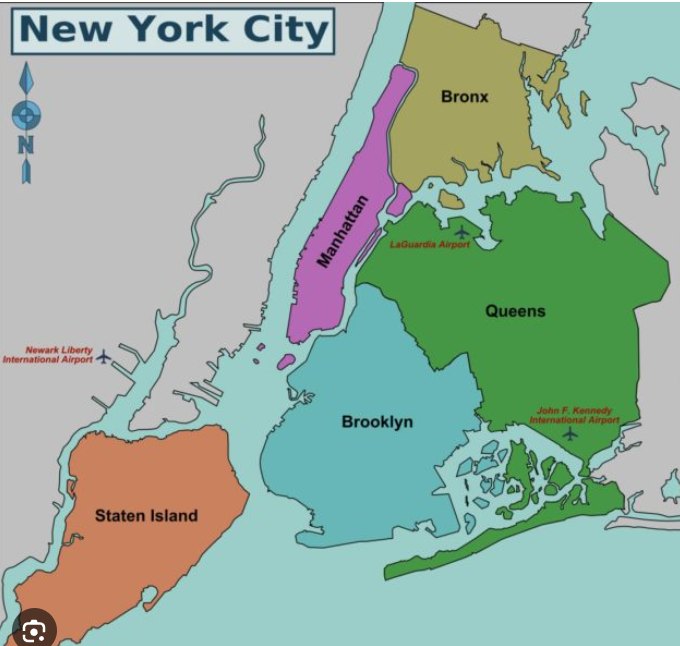

### 'Weekday' Modèle DBSCAN – Clustering non supervisé pour détecter les zones chaudes
---

In [13]:
# Zones chaudes jours de semaine

jours = df_sample['Weekday'].unique()

for jour in jours:
    df_jour = df_sample[df_sample['Weekday'] == jour].copy()
    
    coords = df_jour[['Lat', 'Lon']]
    
    # Clustering DBSCAN
    dbscan = DBSCAN(eps=0.01, min_samples=10)  # eps en degrés (~1 km)
    df_jour['Cluster_dbscan'] = dbscan.fit_predict(coords)
    
    # Carte
    fig = px.scatter_mapbox(
        df_jour[df_jour['Cluster_dbscan'] != -1],  # ignorer les outliers
        lat="Lat",
        lon="Lon",
        color="Cluster_dbscan",
        height=500,
        zoom=10,
        title=f"Zones chaudes le {jour} (DBSCAN)",
        mapbox_style="carto-positron"
    )
    fig.show()

# Visualisation densité par jour de la semaine en un seul graph
# Copy DataFrame 
df_densite = df_sample.copy()

# Ajouter la colonne Cluster DBSCAN
coords = df_densite[['Lat', 'Lon']]
dbscan = DBSCAN(eps=0.01, min_samples=10)
df_densite['Cluster_dbscan'] = dbscan.fit_predict(coords)

# On enlève les outliers (-1)
df_clusters = df_densite[df_densite['Cluster_dbscan'] != -1]

# Compter le nombre de points par jour
df_weekday = df_clusters.groupby('Weekday').size().reset_index(name='Nb_points')
print(df_weekday.sum())
print(df_weekday)

# Visu en barres
fig = px.bar(
  df_weekday.sort_values('Nb_points', ascending=False),  # optionnel : trier par nb de points
    x='Weekday',
    y='Nb_points',
    title='Zones chaudes par jour (DBSCAN)',
    labels={'Weekday':'Jour', 'Nb_points':'Nombre de points clusterisés'},
    color='Nb_points',
    text='Nb_points'
)
fig.show()

Weekday      FridayMondaySaturdaySundayThursdayTuesdayWedne...
Nb_points                                                20061
dtype: object
     Weekday  Nb_points
0     Friday       3104
1     Monday       2678
2   Saturday       3104
3     Sunday       2353
4   Thursday       2915
5    Tuesday       3307
6  Wednesday       2600


### 'Time of day' Modèle DBSCAN – Clustering non supervisé pour détecter les zones chaudes
---

In [11]:
# Zones chaudes moment de la journée
# Analyse par moment de la journée
times = df_sample['Time_of_day'].unique()

for time in times:
    df_time = df_sample[df_sample['Time_of_day'] == time].copy()
    
    coords = df_time[['Lat', 'Lon']]
    
    # Clustering DBSCAN
    dbscan = DBSCAN(eps=0.01, min_samples=10)  # eps en degrés (~1 km)
    df_time['Cluster_dbscan'] = dbscan.fit_predict(coords)
    
    # Carte
    fig = px.scatter_mapbox(
        df_time[df_time['Cluster_dbscan'] != -1],  # ignorer les outliers
        lat="Lat",
        lon="Lon",
        color="Cluster_dbscan",
        height=500,
        zoom=10,
        title=f"Zones chaudes le {time} (DBSCAN)",
        mapbox_style="carto-positron"
    )
    fig.show()

# Visualisation densité par moment de la journéee en un seul graph
# Copy DataFrame 
df_densite = df_sample.copy()

# Ajouter la colonne Cluster DBSCAN
coords = df_densite[['Lat', 'Lon']]
dbscan = DBSCAN(eps=0.01, min_samples=10)
df_densite['Cluster_dbscan'] = dbscan.fit_predict(coords)

# On enlève les outliers (-1)
df_clusters = df_densite[df_densite['Cluster_dbscan'] != -1]

# Compter le nombre de points par jour
df_time = df_clusters.groupby('Time_of_day').size().reset_index(name='Nb_points')
print(df_time)

# Visu en barres
fig = px.bar(
  df_time.sort_values('Nb_points', ascending=False),  # optionnel : trier par nb de points
    x='Time_of_day',
    y='Nb_points',
    title='Zones chaudes par moment de la journée (DBSCAN)',
    labels={'Time_of_day':'Moment de la journée', 'Nb_points':'Nombre de points clusterisés'},
    color='Nb_points',
    text='Nb_points'
)
fig.show()


  Time_of_day  Nb_points
0   Afternoon       5238
1     Evening       5503
2     Morning       4948
3       Night       4372
